In [26]:
import os
import zipfile
import shutil
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks


In [38]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/colon_cancer.zip'
extract_path = '/content/colon_cancer'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import os
import hashlib
import shutil

original_path = '/content/colon_cancer'
clean_base = '/content/colon_cancer_unique'

hashes = set()
os.makedirs(clean_base, exist_ok=True)

for class_folder in os.listdir(original_path):
    class_path = os.path.join(original_path, class_folder)
    clean_class_path = os.path.join(clean_base, class_folder)
    os.makedirs(clean_class_path, exist_ok=True)

    for file in os.listdir(class_path):
        file_path = os.path.join(class_path, file)
        with open(file_path, 'rb') as f:
            file_hash = hashlib.md5(f.read()).hexdigest()

        if file_hash not in hashes:
            hashes.add(file_hash)
            shutil.copy(file_path, os.path.join(clean_class_path, file))
        else:
            print(f"Duplicate found and skipped: {file}")


Duplicate found and skipped: colonn2316.jpeg
Duplicate found and skipped: colonn2839.jpeg
Duplicate found and skipped: colonn3265.jpeg
Duplicate found and skipped: colonn907.jpeg
Duplicate found and skipped: colonn502.jpeg
Duplicate found and skipped: colonn3640.jpeg
Duplicate found and skipped: colonn1993.jpeg
Duplicate found and skipped: colonn3671.jpeg
Duplicate found and skipped: colonn3192.jpeg
Duplicate found and skipped: colonn4276.jpeg
Duplicate found and skipped: colonn877.jpeg
Duplicate found and skipped: colonn1025.jpeg
Duplicate found and skipped: colonn4914.jpeg
Duplicate found and skipped: colonn3589.jpeg
Duplicate found and skipped: colonn3121.jpeg
Duplicate found and skipped: colonn4650.jpeg
Duplicate found and skipped: colonn4785.jpeg
Duplicate found and skipped: colonn1421.jpeg
Duplicate found and skipped: colonn2673.jpeg
Duplicate found and skipped: colonn2270.jpeg
Duplicate found and skipped: colonn2521.jpeg
Duplicate found and skipped: colonn1514.jpeg
Duplicate fou

In [40]:
from sklearn.model_selection import train_test_split

cleaned_path = '/content/colon_cancer_unique'
split_dir = '/content/colon_split_clean'

if os.path.exists(split_dir):
    shutil.rmtree(split_dir)

classes = ['Colon_Adenocarcinoma', 'Colon_Benign_Tissue']
train_dir = os.path.join(split_dir, 'train')
val_dir = os.path.join(split_dir, 'val')
test_dir = os.path.join(split_dir, 'test')

for folder in [train_dir, val_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(folder, cls), exist_ok=True)

# Split and move images
for cls in classes:
    img_paths = os.listdir(os.path.join(cleaned_path, cls))
    train_files, temp = train_test_split(img_paths, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp, test_size=0.5, random_state=42)

    for file_set, target_dir in zip([train_files, val_files, test_files], [train_dir, val_dir, test_dir]):
        for file in file_set:
            src = os.path.join(cleaned_path, cls, file)
            dst = os.path.join(target_dir, cls, file)
            shutil.copy(src, dst)


In [41]:
hashes = set()
duplicate_count = 0

for folder in ['train', 'val', 'test']:
    folder_path = f"/content/colon_split_clean/{folder}"
    for subfolder in os.listdir(folder_path):
        full_path = os.path.join(folder_path, subfolder)
        for file in os.listdir(full_path):
            file_path = os.path.join(full_path, file)
            img_hash = get_hash(file_path)
            if img_hash in hashes:
                duplicate_count += 1
            else:
                hashes.add(img_hash)

print(f"Duplicate images across splits: {duplicate_count}")


Duplicate images across splits: 0


In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

base_path = "/content/colon_split_clean"

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_path, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 6667 images belonging to 2 classes.
Found 1429 images belonging to 2 classes.
Found 1429 images belonging to 2 classes.


In [43]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.9962 - loss: 0.0101
Epoch 1: val_accuracy improved from -inf to 0.99930, saving model to best_model.h5


209/209 ━━━━━━━━━━━━━━━━━━━━ 124s 594ms/step - accuracy: 0.9962 - loss: 0.0101 - val_accuracy: 0.9993 - val_loss: 0.0017
Epoch 2/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.9977 - loss: 0.0087
Epoch 2: val_accuracy improved from 0.99930 to 1.00000, saving model to best_model.h5


209/209 ━━━━━━━━━━━━━━━━━━━━ 123s 587ms/step - accuracy: 0.9977 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 3/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.9950 - loss: 0.0115
Epoch 3: val_accuracy did not improve from 1.00000
209/209 ━━━━━━━━━━━━━━━━━━━━ 143s 592ms/step - accuracy: 0.9950 - loss: 0.0115 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 4/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.9968 - loss: 0.0098
Epoch 4: val_accuracy did not improve from 1.00000
209/209 ━━━━━━━━━━━━━━━━━━━━ 122s 582ms/step - accuracy: 0.9968 - loss: 0.0098 - val_accuracy: 0.9993 - val_loss: 0.0017
Epoch 5/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.9980 - loss: 0.0073
Epoch 5: val_accuracy did not improve from 1.00000
209/209 ━━━━━━━━━━━━━━━━━━━━ 120s 576ms/step - accuracy: 0.9980 - loss: 0.0073 - val_accuracy: 0.9993 - val_loss: 0.0025


In [46]:
# Evaluate on all sets
train_loss, train_acc = model.evaluate(train_gen)
val_loss, val_acc = model.evaluate(val_gen)
test_loss, test_acc = model.evaluate(test_gen)

print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")


209/209 ━━━━━━━━━━━━━━━━━━━━ 113s 542ms/step - accuracy: 0.9994 - loss: 0.0035
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 1.0000 - loss: 0.0018
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.9985 - loss: 0.0059
Train Accuracy: 99.91%
Validation Accuracy: 100.00%
Test Accuracy: 99.86%


45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step
                      precision    recall  f1-score   support

Colon_Adenocarcinoma       1.00      1.00      1.00       713
 Colon_Benign_Tissue       1.00      1.00      1.00       716

            accuracy                           1.00      1429
           macro avg       1.00      1.00      1.00      1429
        weighted avg       1.00      1.00      1.00      1429



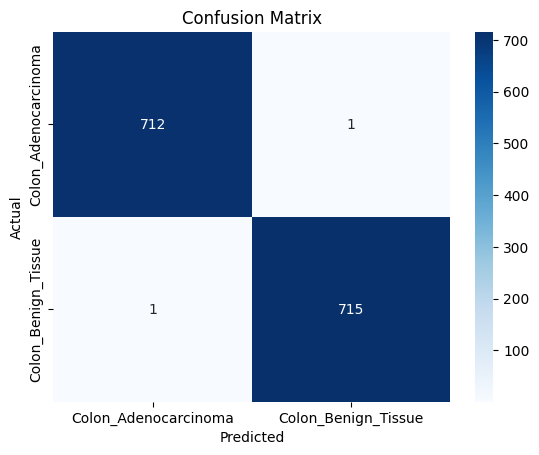

In [47]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_labels, target_names=test_gen.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [48]:
# Save model architecture and weights
model.save("/content/colon_cancer_classifier.h5")
print("Model saved to /content/colon_cancer_classifier.h5")


Model saved to /content/colon_cancer_classifier.h5


In [51]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Load the saved model
model = load_model("/content/colon_cancer_classifier.h5")

# Your class labels (ensure this matches your training)
class_labels = ['Colon_Adenocarcinoma', 'Colon_Benign_Tissue']

# Prediction function
def predict_image(img_path):
    if not os.path.exists(img_path):
        print("Image path does not exist.")
        return

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    print(f"Predicted class: {class_labels[predicted_class]}")


# Example usage
image_path = "/content/colon_split_clean/test/Colon_Adenocarcinoma/colonca1132.jpeg"  # Replace with your actual image path
predict_image(image_path)



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: Colon_Adenocarcinoma


In [52]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Load the saved model
model = load_model("/content/colon_cancer_classifier.h5")

# Your class labels (ensure this matches your training)
class_labels = ['Colon_Adenocarcinoma', 'Colon_Benign_Tissue']

# Prediction function
def predict_image(img_path):
    if not os.path.exists(img_path):
        print("Image path does not exist.")
        return

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    print(f"Predicted class: {class_labels[predicted_class]}")


# Example usage
image_path = "/content/colon_split_clean/test/Colon_Benign_Tissue/colonn1056.jpeg"  # Replace with your actual image path
predict_image(image_path)



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: Colon_Benign_Tissue


In [54]:
import pickle

# Define preprocessing details
preprocess_data = {
    "image_size": (224, 224),
    "class_labels": ['Colon_Adenocarcinoma', 'Colon_Benign_Tissue']
}

# Save preprocessing info
with open("/content/preprocess_config.pkl", "wb") as f:
    pickle.dump(preprocess_data, f)
